In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf
import itertools
import math

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [2]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [3]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [5]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
247029,4213204,/m/0bq8tr,1990-05-18,NaN,1943-02-26,M,1.93,/m/0x67,Bill Duke,47.0,/m/09hz9ly,NaN,/m/05d79k
224440,29146986,/m/0dlm9dq,2011-09-08,Piali Patel,1987-07-08,F,NaN,NaN,Tara D’Souza,24.0,/m/0hhxg__,/m/0hhxh02,/m/0gyv__4
26356,5696805,/m/0d_ndm,2003-07-25,John Rodrigues,1951-01-01,M,NaN,/m/0cqgdq,Nana Patekar,52.0,/m/0jw_4r,/m/0h30kjf,/m/03z_g7
18342,21243478,/m/05c4zr2,1957-01,Pat Dryden,NaN,F,NaN,NaN,Junia Crawford,NaN,/m/0n6snwr,/m/0n70wv_,/m/0n6snwv
127762,9591329,/m/02pl3jt,1981-05-29,NaN,1940-10-16,M,1.80,NaN,Barry Corbin,40.0,/m/0cgndb4,NaN,/m/04vcdj


Let's map the wikipedia_movie_id to the movie name given in movies 'name' column

In [6]:
characters = characters.merge(movies[['wikipedia_id','name']], how='left', left_on='wikipedia_movie_id', right_on='wikipedia_id')
characters.drop('wikipedia_id', inplace=True, axis=1)

In [7]:
characters.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars


## Official IMDb dataset

This dataset includes all IMDb data. https://www.imdb.com/interfaces/

title.basics.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
 - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
 - originalTitle (string) - original title, in the original language
 - isAdult (boolean) - 0: non-adult title; 1: adult title
 - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
 - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
 - runtimeMinutes – primary runtime of the title, in minutes
 - genres (string array) – includes up to three genres associated with the title

title.ratings.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - averageRating – weighted average of all the individual user ratings
 - numVotes - number of votes the title has received

title.crew.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - directors (array of nconsts) - director(s) of the given title
 - writers (array of nconsts) – writer(s) of the given title

name.basics.tsv.gz: information of actors
 - nconst (string) - alphanumeric unique identifier of the name/person
 - primaryName (string)– name by which the person is most often credited
 - birthYear – in YYYY format
 - deathYear – in YYYY format if applicable, else '\N'
 - primaryProfession (array of strings)– the top-3 professions of the person
 - knownForTitles (array of tconsts) – titles the person is known for

In [8]:
imdb_titles = pd.read_csv('./data/imdb/imdb_titles.tsv', na_values='\\N', sep='\t')
imdb_ratings = pd.read_csv('./data/imdb/imdb_ratings.tsv', na_values='\\N', sep='\t')
imdb_crew = pd.read_csv('./data/imdb/imdb_crew.tsv', na_values='\\N', sep='\t')
imdb_people = pd.read_csv('./data/imdb/imdb_people.tsv', na_values='\\N', sep='\t')

In [9]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


In [10]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1738
3,tt0000004,5.6,175
4,tt0000005,6.2,2553


In [11]:
imdb_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [12]:
imdb_people.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0054452,tt0049189,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [13]:
imdb_people.describe()

,birthYear,deathYear
count,568354.000000,208794.000000
mean,1952.249489,1991.615310
std,34.844203,34.748459
min,4.000000,17.000000
25%,1931.000000,1978.000000
50%,1959.000000,2000.000000
75%,1978.000000,2013.000000
max,2022.000000,2022.000000


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [14]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [15]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
622,Yogi Bear,2010,4.6,PG,80,"Animation, Adventure, Comedy","Dec 17, 2010",80000000,100246011,204774690
1309,The Hitchhiker's Guide to the Galaxy,2005,6.8,PG,109,"Adventure, Comedy, Sci-Fi","Apr 29, 2005",45000000,51019112,102746214
2882,The Astronaut's Wife,1999,5.4,R,109,"Drama, Sci-Fi, Thriller","Aug 27, 1999",34000000,10672566,10672566
2638,Seven Psychopaths,2012,7.2,R,110,"Comedy, Crime","Oct 12, 2012",13500000,15024049,33035736
576,Jaws 2,1978,5.8,PG,116,"Adventure, Horror, Thriller","Jun 16, 1978",20000000,102922376,208900376


In [16]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `pageviews`: Number of page views for a movie with a `name`. The value is an weighted aggregation for the pageviews for the period between 01/12/2021 and 30/11/2022. The weight is computed with this formula - `weight = 1 + ((2022 - movie_release_year) / (2022 - min_movie_year))`. The aggregation is accomplished by the `mean` function.

In [17]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [18]:
wikipedia_pageviews.sample(5)

,name,pageviews
17762,Iczer Girl Iczelion,306.159420
43728,The Sword and the Rose,2770.062500
30742,Příběh dušičkový,14.626153
16733,"Hitler, Beast of Berlin",120.734931
16772,Hold That Blonde,143.119565


# Cleaning & Pre-processing of data

In [19]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [20]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [21]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [22]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [23]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [24]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [25]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [26]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [27]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [28]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [29]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [30]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [31]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [32]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [33]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [34]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [35]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [36]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity
215304,6491972,/m/0g7d_m,1998,NaN,1966-05-17,M,1.702,/m/0x67,Hill Harper,31.0,/m/0k5_gq,NaN,/m/030xk5,The Nephew,African Americans,Black
100637,34056177,/m/0hnfdrl,1970-09-09,NaN,NaN,NaN,NaN,NaN,Claude Vega,NaN,/m/0gcg538,NaN,/m/0gcg53c,Bed and Board,NaN,NaN
363615,24407635,/m/07s3tw3,1996-08-08,NaN,NaN,NaN,NaN,NaN,Fadi El-Ghoul,NaN,/m/0fpvtz8,NaN,/m/0fpvtz2,Haifa,NaN,NaN
323991,18760565,/m/04g129n,2011-11-11,Victor,1960-05-08,M,NaN,NaN,Patrick McKenna,51.0,/m/0jxzngv,/m/0jxzngy,/m/03gm5f,Silent But Deadly,NaN,NaN
452205,8326730,/m/026_j27,1962,NaN,1921-01-11,F,NaN,/m/0d7wh,Kathleen Byron,40.0,/m/0gm298b,NaN,/m/092571,Night of the Eagle,British people,White


In [37]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [38]:
def split_list(df, column_name, sep=','):
    df[column_name] = df[column_name].replace(np.nan, '').apply(lambda x: x.split(sep))

In [39]:
def fill_na_with_list(df, column_name):
    df[column_name] = df[column_name].fillna('').apply(list)

In [40]:
split_list(imdb_crew, 'directors')
split_list(imdb_crew, 'writers')
split_list(imdb_titles, 'genres')

In [41]:
imdb_people_dict = dict(zip(imdb_people['nconst'], imdb_people['primaryName']))

In [42]:
imdb_crew['directors'] = imdb_crew['directors'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [43]:
imdb_crew['writers'] = imdb_crew['writers'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [44]:
imdb = pd.merge(pd.merge(imdb_titles, imdb_ratings, how='inner', on='tconst'), imdb_crew, how='inner', on='tconst')

In [45]:
# Free memory
del imdb_titles
del imdb_ratings
del imdb_crew

In [46]:
imdb.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
1052857,tt5375270,short,The Bus,The Bus,0,2016.0,NaN,NaN,"[Drama, Short]",7.0,12,"[Tembot Shovgenov, Azamat Tkhaganov]","[Dzambulat Guchetl, Tembot Shovgenov, Azamat T..."
998298,tt4435350,tvEpisode,Vidur Learns About Duryodhan's Plan,Vidur Learns About Duryodhan's Plan,0,2013.0,NaN,NaN,"[Drama, History, War]",7.8,10,[],[Siddharth Kumar Tewary]
339583,tt0677764,tvEpisode,Germ Warfare,Germ Warfare,0,2000.0,NaN,44.0,"[Crime, Drama, Mystery]",7.7,67,[Duane Clark],[David E. Kelley]
483319,tt10781946,tvEpisode,Jada Pinkett Smith/Rep. Ayanna Pressley/Goo Go...,Jada Pinkett Smith/Rep. Ayanna Pressley/Goo Go...,0,2019.0,NaN,41.0,"[Comedy, Talk-Show]",6.6,21,[Jake Plunkett],[Asher Perlman]
276980,tt0532589,tvEpisode,School for Cowards,School for Cowards,0,1959.0,NaN,60.0,[Western],7.9,33,[Lee Sholem],[George F. Slavin]


In [47]:
imdb.describe()

,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
count,1.253452e+06,1.253191e+06,41948.000000,901787.000000,1.253452e+06,1.253452e+06
mean,1.551795e-02,2.001829e+03,2005.704777,56.207179,6.952086e+00,1.041908e+03
std,1.236008e-01,2.125113e+01,15.357264,96.507384,1.388000e+00,1.729051e+04
min,0.000000e+00,1.874000e+03,1933.000000,0.000000,1.000000e+00,5.000000e+00
25%,0.000000e+00,1.995000e+03,1998.000000,23.000000,6.200000e+00,1.200000e+01
50%,0.000000e+00,2.009000e+03,2011.000000,45.000000,7.100000e+00,2.600000e+01
75%,0.000000e+00,2.016000e+03,2018.000000,86.000000,7.900000e+00,1.010000e+02
max,1.000000e+00,2.022000e+03,2024.000000,51420.000000,1.000000e+01,2.667015e+06


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'averageRating' and to the correponding number of votes 'numVotes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

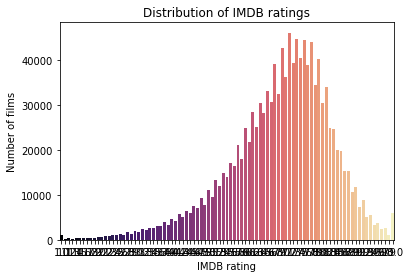

In [48]:
_ = sns.countplot(x='averageRating', data=imdb, palette="magma") \
   .set(title='Distribution of IMDB ratings', xlabel='IMDB rating', ylabel='Number of films')

In [49]:
C = imdb['averageRating'].mean()
m = imdb['numVotes'].min()
v = imdb['numVotes']
R = imdb['averageRating']

In [50]:
imdb['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [51]:
imdb[['originalTitle', 'averageRating', 'WR', 'numVotes']].sort_values('WR', ascending=False).head()

,originalTitle,averageRating,WR,numVotes
853340,Ozymandias,10.0,9.999918,185650
1000173,Unbreakable Souls,10.0,9.993245,2251
1023521,Angels Apocalypse,10.0,9.992627,2062
749029,Final Draft,10.0,9.978922,718
308511,Episode #1.9,10.0,9.975694,622


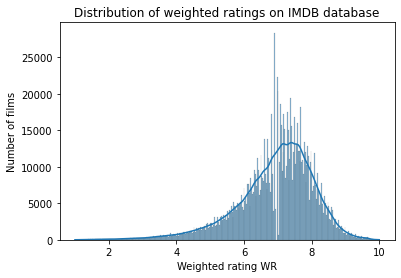

In [52]:
_ = sns.histplot(x='WR', data=imdb, kde=True) \
   .set(title='Distribution of weighted ratings on IMDB database', xlabel='Weighted rating WR', ylabel='Number of films')

### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [53]:
len((imdb['originalTitle'] + imdb['startYear'].astype(str)).unique()) / len(imdb)

0.9297141015371949

In [54]:
imdb.drop_duplicates(subset=['originalTitle', 'startYear'], inplace=True)

In [55]:
len((movies['name'] + movies['release_year'].astype(str)).unique()) / len(movies)

0.9977122863679182

In [56]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [57]:
movies.drop_duplicates(subset=['name', 'release_year'], inplace=True)

In [58]:
imdb.rename({'originalTitle': 'name', 'startYear': 'release_year'}, axis=1, inplace=True)

In [59]:
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float32')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float32')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float32')

In [60]:
movie_feature = movies.merge(imdb, on=['name', 'release_year'], how='left')

In [61]:
# Free memory
del imdb
del movies

In [62]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [63]:
fill_NaN(movie_feature, 'runtime', 'runtimeMinutes')
fill_NaN(movie_feature, 'genres_x', 'genres_y', 'genre')
movie_feature.drop(labels=['runtimeMinutes', 'genres_x', 'genres_y', 'primaryTitle', 'titleType', 'tconst', 'endYear'], axis=1, inplace=True)

In [64]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [65]:
movie_feature.sample(3)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,release_year,release_month,release_day,isAdult,averageRating,numVotes,directors,writers,WR,genre
29108,3361673,/m/097qd6,Town & Country,10372291.0,104.0,[English],[United States of America],2001.0,4.0,27.0,0.0,4.5,5036.0,[Peter Chelsom],"[Michael Laughlin, Buck Henry]",4.502432,"[Romantic comedy, Romance Film, Screwball come..."
50586,5179684,/m/0d6j6t,Khud-daar,NaN,168.0,[Hindi],[India],1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Family Film, Action, Drama]"
46569,32240165,/m/0gxyx67,Khokababu,NaN,158.0,NaN,NaN,2012.0,1.0,14.0,0.0,5.1,287.0,[Shankaraiya],[Shayak Ganguly],5.131714,"[Comedy film, Romance Film]"


In [66]:
movie_feature.describe()

,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,isAdult,averageRating,numVotes,WR
count,8.155500e+04,8.392000e+03,67052.000000,74720.000000,42596.000000,39305.000000,44031.000000,44031.000000,4.403100e+04,44031.000000
mean,1.740360e+07,4.799791e+07,93.715766,1977.460815,6.692201,15.651240,0.002566,6.195617,1.378128e+04,6.224498
std,1.098688e+07,1.122099e+08,60.342111,29.101585,3.483220,8.715734,0.050595,1.155310,7.286329e+04,1.102334
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,1.000000,1.000000,0.000000,1.000000,5.000000e+00,1.131770
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,4.000000,8.000000,0.000000,5.600000,1.070000e+02,5.614247
50%,1.777503e+07,1.063551e+07,93.000000,1985.000000,7.000000,16.000000,0.000000,6.300000,5.160000e+02,6.317251
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,10.000000,23.000000,0.000000,7.000000,2.660500e+03,6.998635
max,3.750192e+07,2.782275e+09,5700.000000,2016.000000,12.000000,31.000000,1.000000,10.000000,2.667015e+06,9.467126


In [67]:
# print(f'There are {(imdb.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


In [68]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

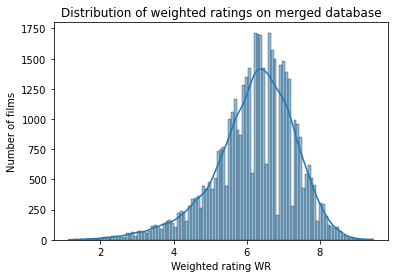

In [69]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [70]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

1.0

### Fill missing budget data from imdb budget dataset

In [71]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
2797,Ready to Rumble,2000,5.4,PG-13,107,"Comedy, Sport","Apr 7, 2000",24000000,12372410,12372410
2447,The Fan,1996,5.9,R,116,"Action, Drama, Sport","Aug 16, 1996",55000000,18582965,18582965
1706,Crossroads,2002,3.5,PG-13,93,"Comedy, Drama, Romance","Feb 15, 2002",12000000,37188667,57000000
2887,Drop Dead Gorgeous,1999,6.6,PG-13,97,"Comedy, Romance, Thriller","Jul 23, 1999",10000000,10571408,10571408
1770,Ad Astra,2019,6.6,PG-13,123,"Adventure, Drama, Mystery","Sep 19, 2019",80000000,50188370,135432019


In [72]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [73]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('float32')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('float32')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('float32')

In [74]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [75]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda el: el.split(', '))

In [76]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.593994,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767752,3.378486,8.437509
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [77]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9254858684323463

In [78]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [79]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [80]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [81]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [82]:
fill_NaN(movie_feature_with_budget,'genre','genres','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

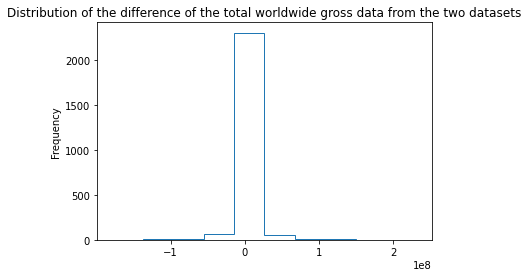

In [83]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

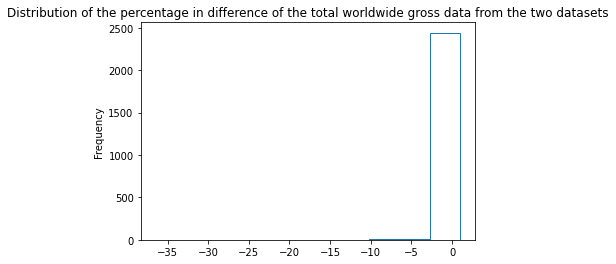

In [84]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [85]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [86]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
1611,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
10379,Restless,163265.0,2772511.0,2609246.0,1598.17
3307,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
30129,Margaret,46495.0,623292.0,576797.0,1240.56
4126,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
56979,Click,237681299.0,237685089.0,3790.0,0.00
57636,G-Force,292810686.0,292817841.0,7155.0,0.00
12989,What Women Want,374111707.0,374105123.0,6584.0,0.00
58624,Butch Cassidy and the Sundance Kid,102308889.0,102310653.0,1764.0,0.00


In [87]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2464.000000
mean,16.458888
std,101.443043
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.924000
90%,34.167000
95%,62.882000


In [88]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15868506493506493

In [89]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
1611,The Son of No One,30680.0,1148578.0
3307,Welcome to Collinwood,336620.0,4606284.0
10379,Restless,163265.0,2772511.0
18706,Restless,NaN,NaN
31576,Restless,NaN,NaN


In [90]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1061
391


count    2.464000e+03
mean     4.148700e+05
std      1.570988e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.997022e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [91]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [92]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [93]:
# Remove merged extra columns 
movie_feature_with_budget.drop([
    'Worldwide Gross', 'Domestic Gross', 'Rating', 'Runtime', 'IMDb', 'release_month_x', 'release_month_y',
    'release_day_x', 'release_day_y', 'genres'
], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'box_office_revenue': 'total_gross'}, axis=1, inplace=True)

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [94]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'total_gross', 'runtime',
       'languages', 'countries', 'release_year', 'isAdult', 'averageRating',
       'numVotes', 'directors', 'writers', 'WR', 'genre', 'Production Budget',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [95]:
movie_feature_with_budget.describe()

,wikipedia_id,total_gross,runtime,release_year,isAdult,averageRating,numVotes,WR,Production Budget,release_day,release_month,profit
count,8.155500e+04,8.392000e+03,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,3.828000e+03,40527.000000,43783.000000,2.464000e+03
mean,1.740360e+07,4.799791e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,4.030960e+07,15.658129,6.707717,7.208180e+07
std,1.098688e+07,1.122099e+08,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,4.480927e+07,8.708538,3.483055,1.442546e+08
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,7.000000e+03,1.000000,1.000000,-1.110072e+08
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,1.100000e+07,8.000000,4.000000,4.951632e+05
50%,1.777503e+07,1.063551e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,2.500000e+07,16.000000,7.000000,2.414130e+07
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,5.000000e+07,23.000000,10.000000,8.700518e+07
max,3.750192e+07,2.782275e+09,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,4.000000e+08,31.000000,12.000000,2.545275e+09


In [96]:
movie_feature_with_budget.head(5)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,numVotes,directors,writers,WR,genre,Production Budget,release_day,release_month,profit
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,55353.0,[John Carpenter],"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN
2,28463795.0,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988.0,0.0,5.7,40.0,[Sølve Skagen],"[Sølve Skagen, Gunnar Staalesen]",5.839121,"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN
3,9363483.0,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN,NaN
4,261236.0,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983.0,NaN,NaN,NaN,NaN,NaN,NaN,[Drama],NaN,NaN,NaN,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [97]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [98]:
df = movie_feature_with_budget.copy()

In [99]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [100]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [101]:
movie_feature_with_budget = df.copy()

In [102]:
movie_feature_with_budget.head(2)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,...,writers,WR,genre,Production Budget,release_day,release_month,profit,profit_modified,total_gross_modified,budget_modified
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,...,"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN,NaN,1.870026e+07,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,...,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN,NaN,NaN,NaN


In [103]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [104]:
wikipedia_pageviews.sample(5)

,name,pageviews
33227,Seenugadu Chiranjeevi Fan,124.690711
10514,Diamond Men,247.005435
44545,The Wisdom of Crocodiles,1252.089262
35184,Star of My Night,41.353755
10763,Dirty O'Neil,368.957510


In [105]:
wikipedia_pageviews.describe()

,pageviews
count,45819.000000
mean,2396.190760
std,10343.997960
min,0.000000
25%,46.054842
50%,230.307230
75%,1041.628953
max,410868.409091


In [106]:
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews, on='name', how='left')

# Free memory
del movie_feature_with_budget
del wikipedia_pageviews

In [107]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,wikipedia_id,runtime,release_year,isAdult,averageRating,numVotes,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,8.155500e+04,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000
mean,1.740360e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491
std,1.098688e+07,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,8.708538,3.483055,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493
min,3.300000e+02,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000
25%,7.320728e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004
50%,1.777503e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585
75%,2.714269e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134
max,3.750192e+07,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091


### Prepare `df_all`

In [108]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

#### Deal with NaN

In [109]:
fill_na_with_list(df_all, 'languages')
fill_na_with_list(df_all, 'countries')
fill_na_with_list(df_all, 'genre')
fill_na_with_list(df_all, 'directors')
fill_na_with_list(df_all, 'writers')

#### Remove irrelevant columns

In [110]:
df_all.drop(['wikipedia_id', 'averageRating', 'numVotes'], axis=1, inplace=True)

#### One hot encoding for list values

In [111]:
df_all_ohe = df_all.copy()

In [112]:
def one_hot_encoding_list(df, column_name, top_count):
    top = pd.Series([el for _list in df[column_name] for el in _list]).value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda _list: [el if el in top else 'Other' for el in _list])
    result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
    result.fillna({f'{column_name}_{el}': 0 for el in list(top) + ['Other']}, inplace=True)
    result.drop([column_name], axis=1, inplace=True)
    return result

In [113]:
def one_hot_encoding(df, column_name, top_count):
    top = df[column_name].value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda el: el if el in top else 'Other')
    result = df.join(pd.get_dummies(df[column_name], prefix=column_name).groupby(level=0).max())
    result.drop([column_name], axis=1, inplace=True)
    return result

In [114]:
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'genre', 25)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'languages', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'countries', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'directors', 30)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'writers', 30)

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
C:\Users\34683\AppData\Local\Temp/ipykernel_22888/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
C:\Users\34683\AppData\Local\Temp/ipykernel_22888/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), pre

#### Expand the list values

In [115]:
df_all_expanded = df_all.copy()

In [116]:
df_all_expanded = df_all_expanded.explode('genre')
df_all_expanded = df_all_expanded.explode('languages')
df_all_expanded = df_all_expanded.explode('countries')
df_all_expanded = df_all_expanded.explode('directors')
df_all_expanded = df_all_expanded.explode('writers')

In [117]:
df_all_expanded.sample(5)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
73016,/m/04j12cj,Law of the West,58.0,NaN,United States of America,1932.0,0.0,Robert N. Bradbury,Robert N. Bradbury,5.730008,Action/Adventure,NaN,NaN,NaN,NaN,NaN,NaN
42627,/m/0cc846d,Captain America: The First Avenger,124.0,English,United States of America,2011.0,0.0,Joe Johnston,Jack Kirby,6.900000,Action/Adventure,22.0,7.0,2.933274e+08,4.729614e+08,179634000.0,112104.086957
71176,/m/08xjf4,The Adventure of Faustus Bidgood,110.0,English,Canada,1986.0,0.0,Andy Jones,Michael Jones,7.368457,Fantasy Comedy,NaN,NaN,NaN,NaN,NaN,98.897233
823,/m/0bz3jx,"Paris, je t'aime",110.0,Arabic,Switzerland,2006.0,0.0,Nobuhiro Suwa,Ethan Coen,7.199983,World cinema,18.0,5.0,NaN,2.241797e+07,NaN,10233.103426
12650,/m/02qhcrr,The Sons of the Great Bear,98.0,German,German Democratic Republic,1966.0,NaN,NaN,NaN,NaN,Western,NaN,NaN,NaN,NaN,NaN,75.368577


For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



### Save dataframe to avoid running pre-processing

In [118]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')
df_all_expanded.to_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8')
df_all_ohe.to_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8')
characters.to_csv('./handled_data/dataframes/characters.csv',encoding='utf-8')

### Read processed dataframe to avoid running pre-processing

In [119]:
import ast
df_all = pd.read_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8',index_col=0, na_values='',converters={column :ast.literal_eval for column in ['languages', 'countries', 'directors', 'writers', 'genre']})
df_all_expanded = pd.read_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8',index_col=0)
df_all_ohe = pd.read_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8',index_col=0)
characters = pd.read_csv('./handled_data/dataframes/characters.csv',encoding='utf-8',index_col=0)

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/3425677836.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_ohe = pd.read_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8',index_col=0)


# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/2314911968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


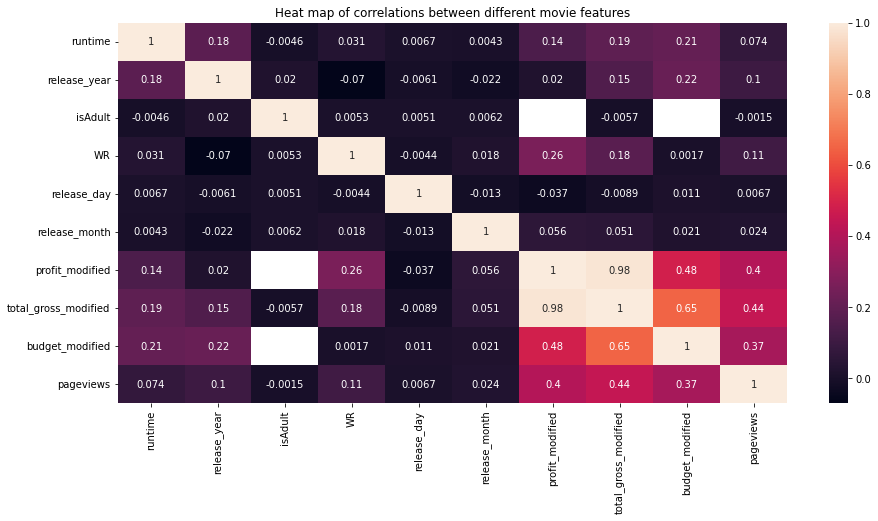

In [120]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Interesting correlations: 
Our different success indicators are not too correlated (WR, profit_modified, pageviews) 

### Creation of unique success score

In order to investigate the relation between movie features and success, it would be practical to have a unique movie success score. Seeing how the weighted ratings, the profit, and the number of pageviews are uncorrelated, a movie that is successful in time (high pageviews) might however not be the most profitable (high profit), same thing for IMDB rating. 

In [121]:
# We standardise each success feature
df_all['WR_std'] = (df_all['WR'] - df_all['WR'].mean())/df_all['WR'].std()
df_all['profit_modified_std'] = (df_all['profit_modified'] - df_all['profit_modified'].mean())/df_all['profit_modified'].std()
df_all['pageviews_std'] = (df_all['pageviews'] - df_all['pageviews'].mean())/df_all['pageviews'].std()
df_all['total_gross_modified_std'] = (df_all['total_gross_modified'] - df_all['total_gross_modified'].mean())/df_all['total_gross_modified'].std()



In [122]:
# We L2 normalise each success feature
df_all['WR_norm'] = df_all['WR'] / np.sqrt(np.square(df_all['WR']).sum(axis=0))
df_all['profit_modified_norm'] = df_all['profit_modified'] / np.sqrt(np.square(df_all['profit_modified']).sum(axis=0))
df_all['pageviews_norm'] = df_all['pageviews'] / np.sqrt(np.square(df_all['pageviews']).sum(axis=0))
df_all['total_gross_modified_norm'] = df_all['total_gross_modified'] / np.sqrt(np.square(df_all['total_gross_modified']).sum(axis=0))



In [123]:
df_all[['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm']].describe()

,WR_std,profit_modified_std,pageviews_std,WR_norm,profit_modified_norm,pageviews_norm
count,4.403100e+04,2464.000000,4.682300e+04,44031.000000,2464.000000,46823.000000
mean,-3.061251e-16,0.000000,-1.214006e-18,0.004693,0.009101,0.001068
std,1.000000e+00,1.000000,1.000000e+00,0.000831,0.017976,0.004496
min,-4.619948e+00,-1.256965,-2.374549e-01,0.000853,-0.013495,0.000000
25%,-5.535986e-01,-0.502702,-2.333669e-01,0.004233,0.000064,0.000018
50%,8.414206e-02,-0.334384,-2.167655e-01,0.004763,0.003090,0.000093
75%,7.022702e-01,0.103076,-1.424055e-01,0.005276,0.010954,0.000427
max,2.941601e+00,16.706445,3.543684e+01,0.007137,0.309422,0.160405


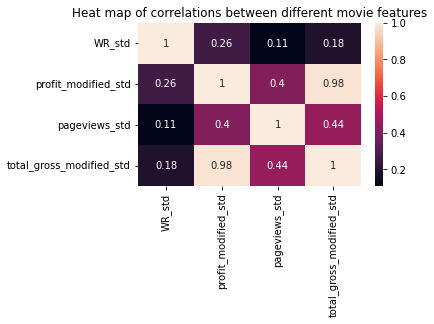

In [124]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_std','profit_modified_std','pageviews_std','total_gross_modified_std']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

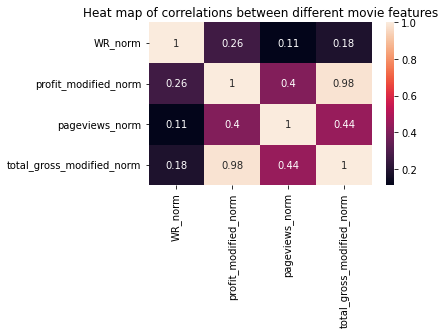

In [125]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_norm','profit_modified_norm','pageviews_norm','total_gross_modified_norm']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

There is still no strong correlations between success features. This indicates that the different scores are independent. Therefore, we create a single movie score based on the rank of each movie for individual scores. The best movie according to each individual feature will thus be ranked with score 1.

In [126]:
# Drop columns since unused 
df_all.drop(['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm'],axis=1,inplace=True)

In [127]:
# Rating of movies according to feature 1: WR : Score 1 'S1'
df_all.sort_values(by='WR',ascending=False,inplace=True)
df_all['S1'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 2: profit_modified : Score 2 'S2'
df_all.sort_values(by='profit_modified',ascending=False,inplace=True)
df_all['S2'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 3: total_gross_modified : Score 3 'S3'
df_all.sort_values(by='total_gross_modified',ascending=False,inplace=True)
df_all['S3'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 4: pageviews : Score 4 'S4'
df_all.sort_values(by='pageviews',ascending=False,inplace=True)
df_all['S4'] = np.arange(1, len(df_all)+1)

# Number of movies: 
N_movies = len(df_all)

To make sure the movie i single rank is not redundant with rank of movie j , we create a score by taking the best (weighted minimum) of the three ranks. 

In [128]:
r1 = df_all['S1'][0]
r2 = df_all['S2'][0]
r3 = df_all['S3'][0]
r4 = df_all['S4'][0]

R1 = {r1, r2, r3, r4}
R2 = R1 - {min(R1)} # Remove min R1
R3 = R1 - {min(R1), min(R2)}
R4 = R1 - {min(R1), min(R2), min(R3)}

print(r1,r2,r3,r4)

39158 39322 3824 1786


In [129]:
score = min(R1) * 2**(3 * math.log2(N_movies) + 1) + min(R2) * 2**(2 * math.log2(N_movies) + 1) + min(R3) * 2**( math.log2(N_movies) + 1) + min(R4)


In [130]:
score

2.0134540131370427e+18

In [131]:


min(R1) * N^2 + min(R2) * N + min(R3) * 1
R1 = {r1, r2, r3}
R2 = R1 \ min(R1) // Remove min R1
R3 = R1 \ {min(R1), min(R2)}
N > Number_of_movies
2^(log2(num_movies) + 1) // +1 so we don’t have overlap


SyntaxError: unexpected character after line continuation character (Temp/ipykernel_22888/2057631166.py, line 3)

In [132]:
# Create aggregated score for movie: 
df_all['Score'] = df_all[['S1','S2','S3','S4']].min(axis=1)

In [133]:
df_all.sort_values(by='Score').head(10)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
1294,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,NaN,NaN,410868.409091,NaN,NaN,44616,44630,46108,1,1
22040,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,NaN,NaN,NaN,NaN,NaN,1,2465,8393,50629,1
23686,/m/0bth54,Avatar,178.0,"[English, Spanish]","[United States of America, United Kingdom]",2009.0,0.0,[James Cameron],[James Cameron],7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46824,1
57928,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,6.186567e+08,86755500.0,371788.721591,3.724103,0.041630,95,91,121,2,2
4290,/m/06_vgr3,The Ape,81.0,[Swedish],[Sweden],2009.0,0.0,[Joe Pinkerton],[Joe Pinkerton],9.466483,...,NaN,NaN,NaN,NaN,NaN,2,2466,8394,50630,2
22242,/m/0dr_4,Titanic,194.0,"[Italian, English, French, Swedish, Russian, G...",[United States of America],1997.0,0.0,[James Cameron],[James Cameron],7.899996,...,2.916816e+09,266940000.0,NaN,19.177891,0.196273,1636,2,2,46825,2
81555,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,477520000.0,321330.244565,NaN,NaN,81556,81556,81556,3,3
28169,/m/062zm5h,The Avengers,137.0,"[Russian, English]",[United States of America],2012.0,0.0,[Joss Whedon],"[Joss Whedon, Zak Penn]",7.999996,...,1.939737e+09,288697500.0,770.791996,12.607598,0.130525,1255,3,3,14178,3
31290,/m/05mxr92,I Love You,47.0,[Oriya],[India],2005.0,0.0,[Kelly Makin],"[Ron Cowen, Daniel Lipman, Del Shores]",9.460559,...,NaN,NaN,NaN,NaN,NaN,3,2467,8395,50631,3
81586,NaN,Spider-Man: Homecoming,133.0,[],[],2017.0,NaN,[],[],NaN,...,NaN,208915000.0,311412.870059,NaN,NaN,81587,81587,81587,4,4


### Create success score for movie features

Since we would like to compute the added value of movie features, we want to calculate scores for particular features. In particular, we are interested in estimating a score for combinations of features. For instance, two actors combined together might bring an additional value to a movie that they wouldn't if they were acting independently. We thus want to calculate a weight of actor and director pairs.

In [134]:
def score_movie_element(df, column_name):
    df = df.dropna(subset=[column_name], axis=0)
    df = df.explode(column_name)
    df = df_all.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    return df

In [135]:
def score_movie_element_groups(df, column_name):
    df = df.copy().dropna(subset=[column_name], axis=0)
    df[column_name] = df[column_name].apply(lambda x: list(itertools.combinations(set(x), 2)))
    df = df[df[column_name].map(lambda d: len(d)) > 0]
    df = df.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    df = df.rename({'count':'num_movies'},axis=1)
    df_AB = pd.DataFrame(df[column_name].tolist()).add_prefix(column_name).reset_index(drop=True)
    df[df_AB.columns] = df_AB
    return df

We want to weight the score by the number of movies: 
weighted rating (Score) = score * number of movies / total number of movies
where:
- R = mean score of feature i accross all movies
- v = number of movies in which feature i plays a role
- nmb_votes = number of movies total

In [136]:
def weighted_rating(df, column_score, column_nmb_movies): # Alternative VERSION
    R = df[column_score]
    v = df[column_nmb_movies]
    nmb_votes = df[column_nmb_movies].sum()
    WR = R*v / nmb_votes
    
    df[column_score] = WR # Update score column
    return df

As done with IMDB rating, we want to weight the score by the number of movies: 
weighted rating (Score) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 
where:
- R = mean score of feature i accross all movies
- v = number of movies in which feature i plays a role
- m = minimum number of movies: 1
- C = mean score accross all features

In [137]:
def weighted_rating(df, column_score, column_nmb_movies):
    R = df[column_score]
    v = df[column_nmb_movies]
    m = df[column_nmb_movies].min()
    C = df[column_score].mean()
    WR = (v/(v+m)) * R + (m/(v+m)) * C  
    WR = WR / WR.min() # Trick to have scores starting at 1
    df[column_score] = WR # Update score column
    return df

#### Added value of actor pairs

In [138]:
actors = characters.dropna(subset=['actor_name'], axis=0).groupby('freebase_movie_id')['actor_name'].apply(list).to_frame().reset_index()

In [139]:
df_all = pd.merge(df_all, actors, left_on='freebase_id', right_on='freebase_movie_id', how='left').drop(columns=['freebase_movie_id'])

In [140]:
df_all.sample(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name
39975,/m/0642cwk,A Nice Neighbor,102.0,[Hungarian],[Hungary],1979.0,NaN,[],[],NaN,...,NaN,22.847908,NaN,NaN,76291,76295,76472,39976,39976,"[László Szabó, Margit Dajka, Lajos Szabo, Ági ..."
75914,/m/0jt0p_0,Ruby,90.0,[English],[Italy],2013.0,NaN,[],[],NaN,...,NaN,NaN,NaN,NaN,68166,68175,68680,75915,68166,NaN
17849,/m/0gy7s3p,Captain Caution,86.0,[],[United States of America],1940.0,0.0,[Richard Wallace],"[Kenneth Roberts, Grover Jones]",5.522068,...,NaN,476.733202,NaN,NaN,34020,34446,36800,17850,17850,[Victor Mature]


In [141]:
actors_score = score_movie_element(df_all, 'actor_name')

In [142]:
# Add number of movies:
characters['num_movies'] = characters.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')

In [143]:
actors_score = actors_score.merge(characters[['actor_name','num_movies']].drop_duplicates(['actor_name']),on='actor_name',how='inner')
actors_score.head()

,actor_name,count,Score,num_movies
0,Cesarine Prinz\t,2,42857.0,2.0
1,Daniel Newman,1,29590.0,1.0
2,'Big Bill' Giddinger,1,9916.0,1.0
3,'Big' Lee,1,15795.0,1.0
4,'Chicken' Holleman,1,3205.0,1.0


In [144]:
actors_score[actors_score['num_movies'] != actors_score['count']]

,actor_name,count,Score,num_movies
16,50 Cent,22,23618.454545,23.0
27,A. Bromley Davenport,5,49198.200000,2.0
121,Aahuthi Prasad,22,22235.954545,23.0
287,Abbas,41,21480.195122,40.0
442,Abhirami,12,22215.750000,13.0
...,...,...,...,...
133163,Zeenath,2,11535.000000,1.0
133413,Zion Lee,2,39989.500000,1.0
133600,Zrinka Cvitešić,4,25774.000000,5.0
133726,Álvaro Rodríguez,3,26561.666667,2.0


In [145]:
characters[characters['actor_name']=='Élcio Sodré']

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity,num_movies
434165,10093225,/m/02q1l3q,1996-04-01,Imediato,NaN,M,NaN,NaN,Élcio Sodré,NaN,/m/0jq6hlg,/m/0jq6hlk,/m/0jq6f3z,Cassiopéia,NaN,NaN,2.0
434166,10093225,/m/02q1l3q,1996-04-01,Capitão,NaN,M,NaN,NaN,Élcio Sodré,NaN,/m/0jq6f3n,/m/0jq6f3r,/m/0jq6f3z,Cassiopéia,NaN,NaN,2.0


In [146]:
# Weight score by number of movies: 
actors_score = weighted_rating(actors_score, 'Score', 'num_movies')

In [147]:
actors_score.sort_values(by='Score').head()

,actor_name,count,Score,num_movies
760,Adam Sandler,40,1.000000,40.0
4301,Allen Covert,17,1.357098,17.0
29938,Devon Murray,8,1.542003,8.0
83047,Marlon Wayans,17,1.566435,17.0
3699,Alfred Enoch,7,1.588069,7.0


In [148]:
# Compute score of actor pairs
actor_pairs_score = score_movie_element_groups(df_all, 'actor_name')
# Weight score by number of movies: 
actor_pairs_score = weighted_rating(actor_pairs_score, 'Score', 'num_movies')

In [149]:
actor_pairs_score.sort_values(by='Score', inplace=True)

Top 10 actor collaboration

In [150]:
actor_pairs_score.head(10)

,actor_name,num_movies,Score,actor_name0,actor_name1
1241159,"(Maggie Smith, Geraldine Somerville)",9,1.000000,Maggie Smith,Geraldine Somerville
564114,"(Emma Watson, Geraldine Somerville)",9,1.005310,Emma Watson,Geraldine Somerville
34552,"(Alan Rickman, Warwick Davis)",9,1.006437,Alan Rickman,Warwick Davis
564178,"(Emma Watson, Robbie Coltrane)",9,1.026070,Emma Watson,Robbie Coltrane
564069,"(Emma Watson, Alan Rickman)",8,1.068020,Emma Watson,Alan Rickman
409211,"(Daniel Radcliffe, Robbie Coltrane)",8,1.068020,Daniel Radcliffe,Robbie Coltrane
1241335,"(Maggie Smith, Robbie Coltrane)",8,1.068020,Maggie Smith,Robbie Coltrane
1241027,"(Maggie Smith, Alan Rickman)",8,1.068020,Maggie Smith,Alan Rickman
1671865,"(Robbie Coltrane, Alan Rickman)",8,1.068020,Robbie Coltrane,Alan Rickman
1943585,"(Tom Felton, Bonnie Wright)",8,1.068020,Tom Felton,Bonnie Wright


Bottom 10 actor collaboration

In [151]:
actor_pairs_score.tail(10)

,actor_name,num_movies,Score,actor_name0,actor_name1
905027,"(Jens Okking, Udo Kier)",2,31.938826,Jens Okking,Udo Kier
1396868,"(Milivoje ""Mića"" Tomić, Slavko Štimac)",3,31.950517,"Milivoje ""Mića"" Tomić",Slavko Štimac
2016831,"(Vjenceslav Kapural, Vanja Drach)",2,32.024115,Vjenceslav Kapural,Vanja Drach
2016825,"(Vjenceslav Kapural, Nada Gacesic)",2,32.024115,Vjenceslav Kapural,Nada Gacesic
1447660,"(Neferteri Shepherd, Jami Ferrell)",2,32.126749,Neferteri Shepherd,Jami Ferrell
847550,"(Jami Ferrell, Shannon Stewart)",2,32.126749,Jami Ferrell,Shannon Stewart
1447667,"(Neferteri Shepherd, Shannon Stewart)",2,32.126749,Neferteri Shepherd,Shannon Stewart
1429213,"(Nagma, Vijayakumar)",2,32.234925,Nagma,Vijayakumar
35380,"(Alan Wilder, Andrew Fletcher)",7,33.009159,Alan Wilder,Andrew Fletcher
1137810,"(Lakshmi Rai, Jagathi Sreekumar)",5,33.162247,Lakshmi Rai,Jagathi Sreekumar


#### Added value of director pairs

In [152]:
directors_score = score_movie_element(df_all, 'directors')

In [153]:
df_all.columns

Index(['freebase_id', 'name', 'runtime', 'languages', 'countries',
       'release_year', 'isAdult', 'directors', 'writers', 'WR', 'genre',
       'release_day', 'release_month', 'profit_modified',
       'total_gross_modified', 'budget_modified', 'pageviews',
       'total_gross_modified_std', 'total_gross_modified_norm', 'S1', 'S2',
       'S3', 'S4', 'Score', 'actor_name'],
      dtype='object')

In [154]:
# Movies with multiple directors:
director_pairs_score = score_movie_element_groups(df_all, 'directors')

In [155]:
# Weight score by number of movies: 
directors_score = weighted_rating(directors_score, 'Score', 'num_movies')

KeyError: 'num_movies'

In [ ]:
actors_score.sort_values(by='Score_weighted').head()

In [ ]:
director_pairs_score.sort_values(by='Score',inplace=True)
director_pairs_score.sample(10)

Top 10 director collaboration

In [ ]:
director_pairs_score.head(10)

Bottom 10 director collaboration

In [ ]:
director_pairs_score.tail(10)

#### Added value of genre combination

In [ ]:
genre_score = score_movie_element(df_all, 'genre')

In [ ]:
genre_pairs_score = score_movie_element_groups(df_all, 'genre')

Top 10 genre combination

In [156]:
genre_pairs_score.sort_values(by='Score',inplace=True)
genre_pairs_score.head(10)

NameError: name 'genre_pairs_score' is not defined

Bottom 10 genre combination

In [157]:
genre_pairs_score.tail(10)

NameError: name 'genre_pairs_score' is not defined

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the gross revenue.

In [158]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 82605 movies in out dataset, we have the release month information for 43783 movies which is a big enough dataset to be representative.


In [159]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

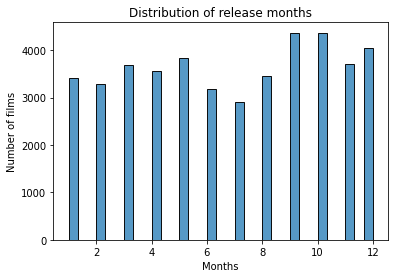

In [160]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [161]:
df_release=df_release.sort_values(by='release_month', ascending=True)

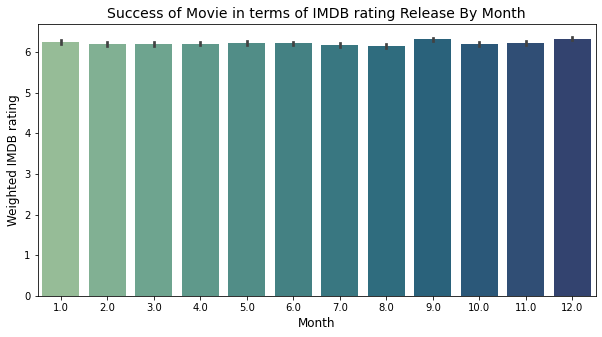

In [162]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

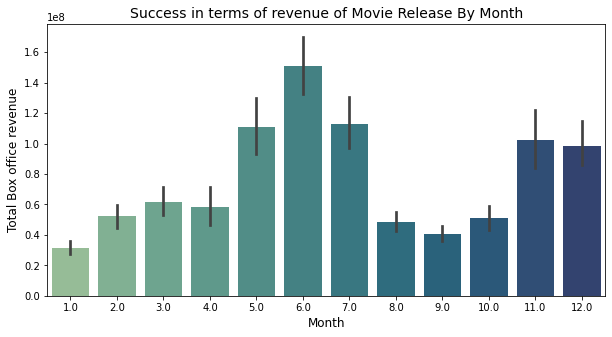

In [163]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. We see that movies released in summer and in the end of the year are more successful.  Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. It interesting to note that these results coincide with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [164]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['budget_modified'].count()} movies.")


Out of 82605 movies in out dataset, we have the profit information for 2464 movies, total gross revenue information for 8392 movies , budget information for 3828 movies.


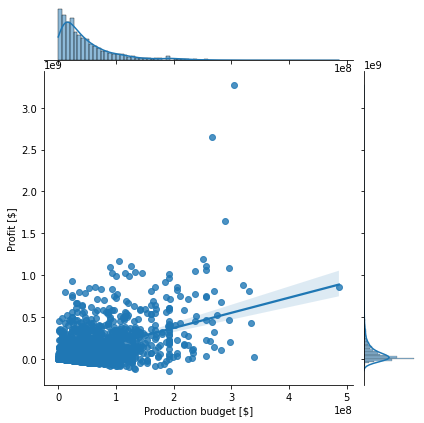

In [165]:
h = sns.jointplot(data=df_all, x='budget_modified', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

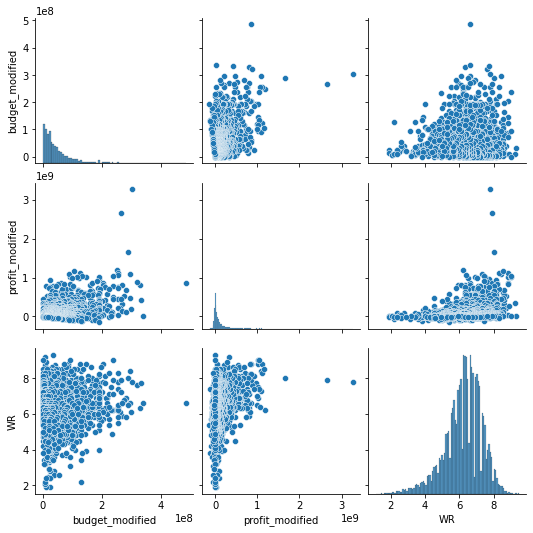

In [166]:
sns.pairplot(df_all[['budget_modified','profit_modified','WR']]);

### Top 20 most profitable movies

In [167]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

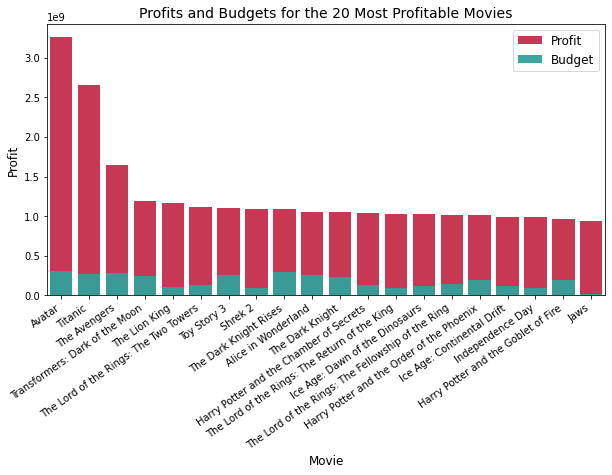

In [168]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

## Impact of director

In [169]:
(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False

0         True
0        False
0        False
0        False
0        False
         ...  
82603    False
82603    False
82604     True
82604    False
82604    False
Length: 916591, dtype: bool

In [170]:
df_all_expanded.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Thriller,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,John Carpenter,4.900185,Thriller,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Science Fiction,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,John Carpenter,4.900185,Science Fiction,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Horror,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439


In [171]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all_expanded[(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False]['directors'].count()} movies coming from the IMDB data set.")

Out of 82605 movies in out dataset, we have the director information for 43724 movies coming from the IMDB data set.


In [172]:
df_director = df_all_expanded.dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors']) # Remove NaN directors

In [173]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

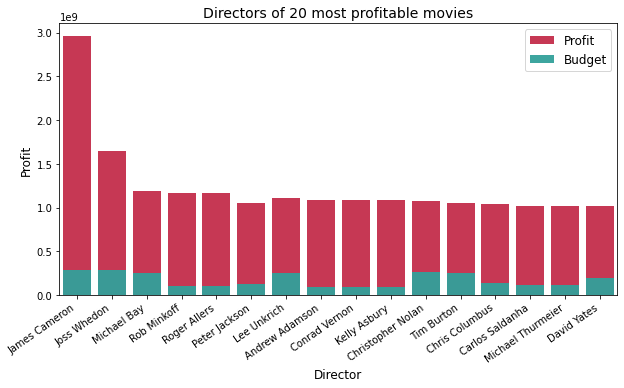

In [174]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [175]:
Top20_ProfitableMovies['directors']

23686        James Cameron
22242        James Cameron
28169          Joss Whedon
18633          Michael Bay
21419          Rob Minkoff
21419         Roger Allers
8815         Peter Jackson
69462          Lee Unkrich
59304       Andrew Adamson
59304        Conrad Vernon
59304         Kelly Asbury
54637    Christopher Nolan
9713            Tim Burton
38115    Christopher Nolan
41152       Chris Columbus
80736        Peter Jackson
38400      Carlos Saldanha
38400    Michael Thurmeier
79796        Peter Jackson
17912          David Yates
Name: directors, dtype: object

## Impact of actors

In order to assess the added value of actors to a movie's success, it is necessary to define the success of individual actors. To do this, we first create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`.

In [176]:
characters
pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name_x,actor_age_at_movie_release,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name_y
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453620,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,...,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō..."
453621,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,...,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō..."
453622,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,...,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]"
453623,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,...,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]"


In [177]:
characters.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name', 'ethnicity_label',
       'major_ethnicity', 'num_movies'],
      dtype='object')

In [178]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name_x',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name_x',
       'ethnicity_label', 'major_ethnicity', 'num_movies', 'freebase_id',
       'name_y', 'runtime', 'languages', 'countries', 'release_year',
       'isAdult', 'directors', 'writers', 'WR', 'genre', 'release_day',
       'release_month', 'profit_modified', 'total_gross_modified',
       'budget_modified', 'pageviews', 'total_gross_modified_std',
       'total_gross_modified_norm', 'S1', 'S2', 'S3', 'S4', 'Score',
       'actor_name_y'],
      dtype='object')

In [179]:
actors

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name_x,actor_age_at_movie_release,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name_y
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453620,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,...,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō..."
453621,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,...,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō..."
453622,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,...,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]"
453623,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,...,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]"


In [180]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors = actors[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity', 'WR']]
actors = actors.dropna(subset=['freebase_actor_id'])
#actors['mean_WR'] = actors.groupby(by=['freebase_actor_id']).mean(numeric_only=True)['WR']

actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors['WR_mean'] = actors[['freebase_actor_id', 'WR']].groupby(by=['freebase_actor_id']).transform('mean')
actors.drop(['freebase_movie_id'], axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)


KeyError: "['actor_name'] not in index"

In [ ]:
characters.groupby('actor_name').count()

In [181]:
#Apply weighting to score
WR_actors_mean = np.mean(actors.WR_mean)
min_movies = 1

def isNan(value):
    return value!=value

def get_weigthed_WR(WR, num_movies):
    if not isNan(WR) and not isNan(num_movies):
        if num_movies > min_movies:
            return num_movies/(num_movies + min_movies) * WR + min_movies/(num_movies + min_movies) * WR_actors_mean
    return np.nan

actors['WR'] = actors.apply(lambda row: get_weigthed_WR(row['WR_mean'], row['num_movies']), axis=1)



AttributeError: 'DataFrame' object has no attribute 'WR_mean'

In [182]:
actors.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name_x,actor_age_at_movie_release,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name_y
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,..."


In [183]:
top_20_actors = actors.dropna(subset=['WR']).sort_values(by='WR', ascending=False).iloc[0:20]

top_20_actors.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name_x,actor_age_at_movie_release,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name_y
61949,7128570,/m/0h5ndj,2008,NaN,1970-05-04,M,1.892,/m/044038p,Will Arnett,37.0,...,NaN,NaN,NaN,NaN,1.0,2465.0,8393.0,50629.0,1.0,[Will Arnett]
12357,23819636,/m/06_vgr3,2009-09-01,Jonas vän,1990-04-01,M,NaN,NaN,Samuel Haus,19.0,...,NaN,NaN,NaN,NaN,2.0,2466.0,8394.0,50630.0,2.0,"[Eva Rexed, Olle Sarri, Sean Pietrulewicz, Nic..."
12356,23819636,/m/06_vgr3,2009-09-01,Jonas,NaN,M,NaN,NaN,Niclas Gillis,NaN,...,NaN,NaN,NaN,NaN,2.0,2466.0,8394.0,50630.0,2.0,"[Eva Rexed, Olle Sarri, Sean Pietrulewicz, Nic..."
12355,23819636,/m/06_vgr3,2009-09-01,Sonen,NaN,M,NaN,NaN,Sean Pietrulewicz,NaN,...,NaN,NaN,NaN,NaN,2.0,2466.0,8394.0,50630.0,2.0,"[Eva Rexed, Olle Sarri, Sean Pietrulewicz, Nic..."
12354,23819636,/m/06_vgr3,2009-09-01,Krister,1972-01-20,M,1.790,NaN,Olle Sarri,37.0,...,NaN,NaN,NaN,NaN,2.0,2466.0,8394.0,50630.0,2.0,"[Eva Rexed, Olle Sarri, Sean Pietrulewicz, Nic..."


In [184]:
plt.figure(figsize=(10,5));
sns.barplot(x=top_20_actors['actor_name'],y=top_20_actors['WR'], 
            color='crimson', alpha=0.95, ci=None);
plt.xlabel('Actors', fontsize=12);
plt.title("Top 20 successful actors", fontsize=14);
plt.ylabel('Success score', fontsize=12);
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10);

KeyError: 'actor_name'

<Figure size 720x360 with 0 Axes>

### TO UPDATE ANYTHING BELOW

In [185]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

KeyError: 'Star1'

For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [186]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

KeyError: ['Star1']

In [187]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

NameError: name 'df_main_actor' is not defined

In [188]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

KeyError: 'Star1'

<Figure size 720x360 with 0 Axes>

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [189]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

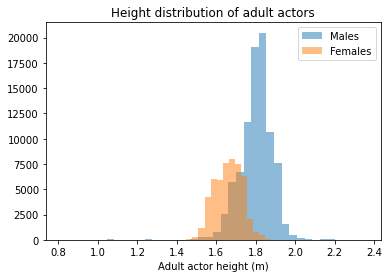

In [190]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

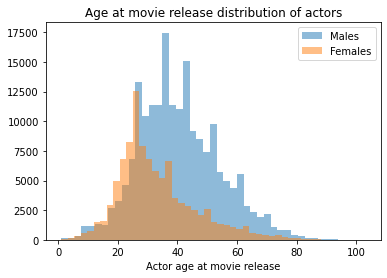

In [191]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

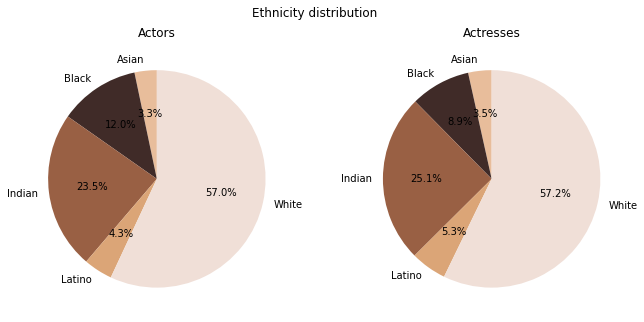

In [192]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

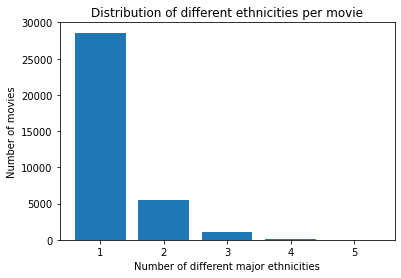

In [193]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

(array(['Asian', 'Black', 'Indian', 'Latino', 'White'], dtype=object), array([ 3010, 10022, 20954,  4179, 51618], dtype=int64))


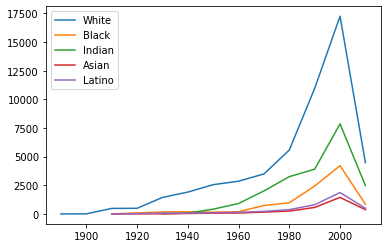

In [194]:
characters_eth = characters.dropna(subset=['major_ethnicity', 'movie_release_date'])
print(np.unique(characters_eth['major_ethnicity'], return_counts=True))

movies_release_year = df_all[['release_year', 'freebase_id']].dropna(subset='freebase_id')
characters_eth = pd.merge(left=characters_eth, right=movies_release_year, how='left', left_on='freebase_movie_id', right_on='freebase_id').drop(columns='freebase_id')
characters_eth['decade'] = np.trunc(characters_eth['release_year']/10)*10
characters_eth = characters_eth[['actor_name', 'decade', 'major_ethnicity', 'freebase_actor_id', 'freebase_movie_id']]
characters_eth_counts = characters_eth.groupby(by=['decade', 'major_ethnicity']).count()

ethnicities = ['White', 'Black', 'Indian', 'Asian', 'Latino']
char_counts_eth = []
decades = np.array([1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010])*1.0

for ethnicity in ethnicities:
    char_counts = characters_eth_counts['actor_name'][:, ethnicity]
    char_counts_eth.append(char_counts)
    total = np.sum(char_counts)
    plt.plot(char_counts)


plt.legend(ethnicities)
plt.show()

# eth_percentages = []
# for idx, eth in enumerate(ethnicities):
#     eth_idx = []
#     for decade in decades:
        

#for dec in decades:
#    print(char_counts_eth[:,dec])




In [195]:
example_eth = '/m/011xg5'
movies_ethnicity_score = characters_eth.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique().to_frame()
movies_ethnicity_score.rename(columns={'major_ethnicity': 'ethnicity_score'}, inplace=True)
movies_ethnicity_score.reset_index(inplace=True)
df_all = pd.merge(df_all, movies_ethnicity_score, how='left', left_on='freebase_id', right_on='freebase_movie_id').drop(columns='freebase_movie_id')

In [197]:
df_all

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name,ethnicity_score
0,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,410868.409091,NaN,NaN,44616,44630,46108,1,1,"[Goran Navojec, Lucija Šerbedžija, Ljubomir Ke...",NaN
1,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,371788.721591,3.724103,0.04163,95,91,121,2,2,"[Belinda McClory, Keanu Reeves, Laurence Fishb...",2.0
2,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,321330.244565,NaN,NaN,81556,81556,81556,3,3,NaN,NaN
3,NaN,Spider-Man: Homecoming,133.0,[],[],2017.0,NaN,[],[],NaN,...,311412.870059,NaN,NaN,81587,81587,81587,4,4,NaN,NaN
4,/m/02dkqh,Doctor Who,89.0,[English],"[United States of America, Canada, United King...",1996.0,0.0,[Geoffrey Sax],"[Matthew Jacobs, Sydney Newman]",6.300334,...,293771.607708,NaN,NaN,23063,24081,27660,5,5,"[Yee Jee Tso, Daphne Ashbrook, Will Sasso, Pau...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82600,NaN,The Prince,93.0,[],[],2014.0,NaN,[],[],NaN,...,NaN,NaN,NaN,82598,82598,82598,82601,82598,NaN,NaN
82601,NaN,Black Christmas,92.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,NaN,NaN,82600,82600,82600,82602,82600,NaN,NaN
82602,NaN,Countdown,90.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,NaN,NaN,82601,82601,82601,82603,82601,NaN,NaN
82603,NaN,Fantasy Island,109.0,[],[],2020.0,NaN,[],[],NaN,...,NaN,NaN,NaN,82602,82602,82602,82604,82602,NaN,NaN


In [196]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')

In [199]:
df_all[df_all['freebase_id'] == example_eth]

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name,ethnicity_score
468,/m/011xg5,A.I. Artificial Intelligence,144.0,[English],[United States of America],2001.0,0.0,[Steven Spielberg],"[Brian Aldiss, Ian Watson, Steven Spielberg]",7.199996,...,50602.114048,1.681457,0.021189,7293,9210,390,469,390,"[Haley Joel Osment, Frances O'Connor, Sam Roba...",3.0


Again, let's split actors in genders

In [200]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [201]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 5
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

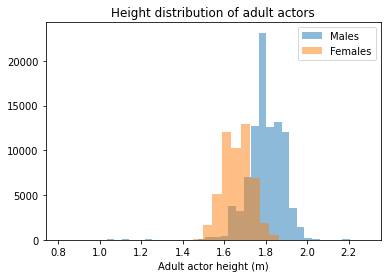

In [202]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

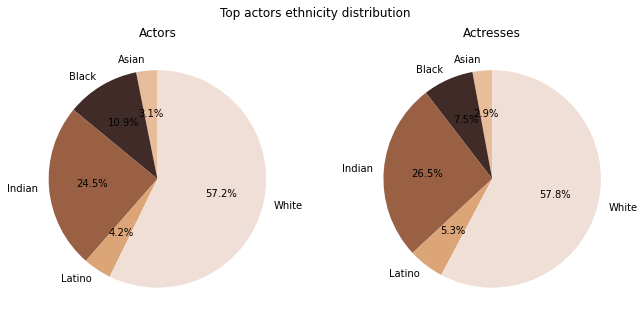

In [203]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

Get score for actors and actresses

In [204]:
df_test = df_all.dropna(subset=['WR'])
df_test.sort_values(by='WR', ascending=False)

# def isNaN(string):
#     return string!=string

# def get_movie_feature_by_id(freebase_movie_id, feature):
#     if not isNaN(freebase_movie_id):
#         #print(freebase_movie_id)
#         a = df_test.loc[df_all['freebase_id'] == freebase_movie_id]
#         if (len(a) > 0):
#             print(a[feature])
#             return a[feature][0].item()
#     return np.nan


# # characters['movie_score'] = characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)

# # characters.dropna(subset='movie_score')

# # characters.iloc[0]['freebase_movie_id']

# characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)


,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name,ethnicity_score
50628,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,NaN,NaN,NaN,1,2465,8393,50629,1,[Will Arnett],NaN
50629,/m/06_vgr3,The Ape,81.0,[Swedish],[Sweden],2009.0,0.0,[Joe Pinkerton],[Joe Pinkerton],9.466483,...,NaN,NaN,NaN,2,2466,8394,50630,2,"[Eva Rexed, Olle Sarri, Sean Pietrulewicz, Nic...",NaN
50630,/m/05mxr92,I Love You,47.0,[Oriya],[India],2005.0,0.0,[Kelly Makin],"[Ron Cowen, Daniel Lipman, Del Shores]",9.460559,...,NaN,NaN,NaN,3,2467,8395,50631,3,"[Bijay Mohanty, Tandra Ray, Hara Patnaik, Anub...",NaN
9983,/m/047q6f0,Herova? Zerova?,5.0,[Tamil],[India],2008.0,0.0,[Priya V.],[Sivakumar],9.414500,...,1434.490613,NaN,NaN,4,2468,8396,9984,4,"[R. Madhavan, Joseph Vijay, Saravanan Sivakuma...",2.0
50631,/m/015g28,Band of Brothers,600.0,"[French, German, English]","[United States of America, United Kingdom]",2001.0,0.0,"[David Frankel, Mikael Salomon, Tom Hanks, Dav...","[Stephen Ambrose, Erik Bork, E. Max Frye, Tom ...",9.399974,...,NaN,NaN,NaN,5,2469,8397,50632,5,"[Matthew Settle, Damian Lewis, Donnie Wahlberg...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65167,/m/0j62hf9,Bug Bites: An Ant's Life,25.0,[English],[United States of America],1998.0,0.0,[],[Michael Schelp],1.354557,...,NaN,NaN,NaN,44027,44041,45543,65168,44027,NaN,NaN
21888,/m/064kw76,Curse of the Zodiac,82.0,[English],[United States of America],2007.0,0.0,[Ulli Lommel],[Ulli Lommel],1.331124,...,288.463192,NaN,NaN,44028,44042,45544,21889,21889,"[Lyn Beausoleil, Cassandra Church, Jack Quinn,...",NaN
11489,/m/0fqp5zx,Santa and the Ice Cream Bunny,96.0,[],[],1972.0,0.0,[Richard Winer],[Hans Christian Andersen],1.318765,...,1132.660079,NaN,NaN,44029,44043,45545,11490,11490,NaN,NaN
65168,/m/04yb5f0,Desh Drohi,139.0,[Hindi],[India],2008.0,0.0,[Jagdish A. Sharma],"[Vimal Kashyap, Kamal Rashid Khan]",1.204863,...,NaN,NaN,NaN,44030,44044,45546,65169,44030,"[Zulfi Syed, Hrishitaa Bhatt, Gracy Singh, Ary...",1.0


## What genres are the most profitable?

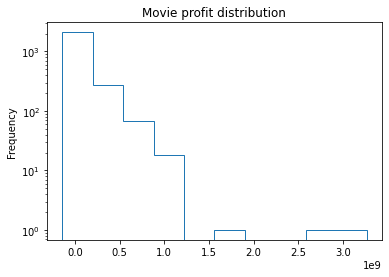

In [205]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [206]:
df_genre = df_all_expanded.dropna(how='all', subset=['genre']).drop_duplicates(['name', 'release_year', 'genre'])

In [207]:
genres = df_genre['genre'].value_counts()

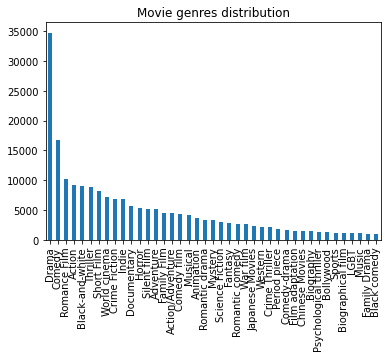

In [208]:
genres[genres > 1000].plot(kind='bar', title='Movie genres distribution');

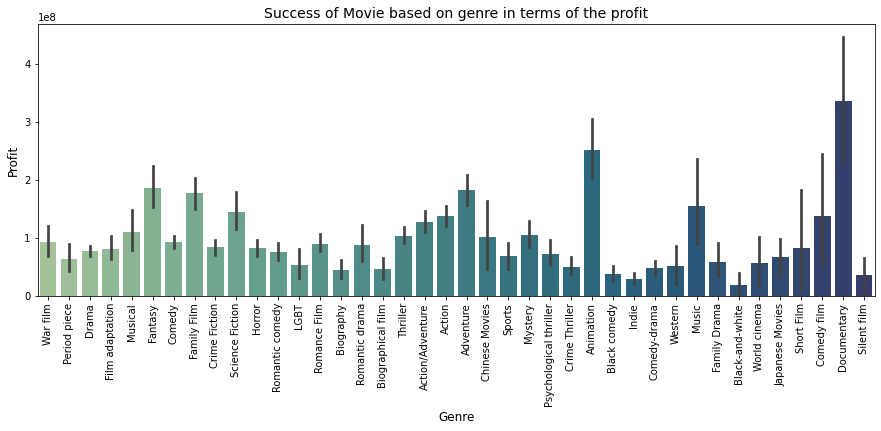

In [209]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre",
    y="profit_modified",
    data=df_genre[df_genre['profit_modified'].notna() & df_genre['genre'].isin(genres[genres > 1000].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## Correlation between the choice of topics and movie profitability can be investigated

In [210]:
df_genre['genre_category'] = df_genre['genre'].astype('category').cat.codes

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/1060159001.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


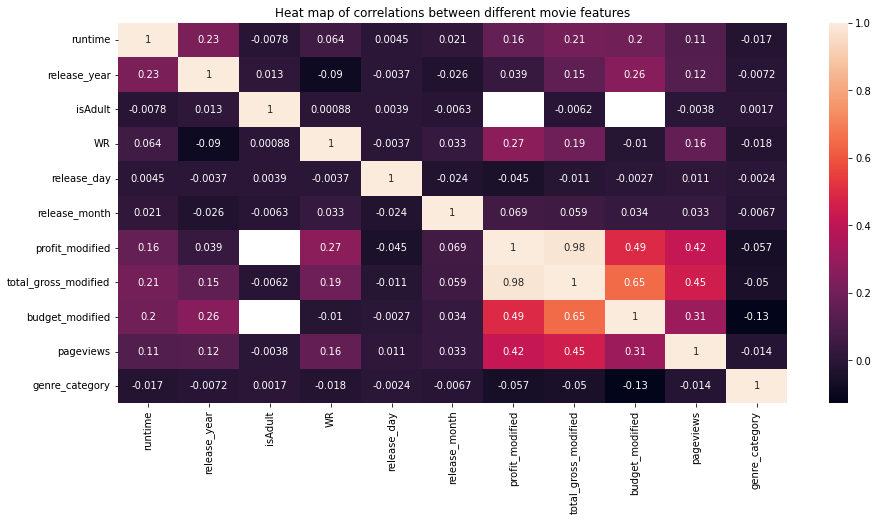

In [211]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [212]:
df_all_ohe.sample(5)

,freebase_id,name,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Val Guest,writers_Warren Foster,writers_William Shakespeare
24429,/m/07hqz2,Ghost in the Machine,95.0,1993.0,0.0,4.603013,29.0,12.0,NaN,5086909.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66799,/m/0bc5ny,High School Musical 2,111.0,2007.0,0.0,5.100151,17.0,8.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81022,/m/0bh923h,Manjupoloru Penkuttiy,NaN,2004.0,NaN,NaN,23.0,7.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39986,/m/0285mx5,Salaryman Kintaro,110.0,1999.0,NaN,NaN,13.0,11.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46369,/m/0bwjg1m,The Star Witness,68.0,1931.0,0.0,6.304781,22.0,8.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
df_all_ohe_cleaned_columns = df_all_ohe.rename({c: c.replace('/', '').replace('.', '').replace(' ', '').replace('\'', '').replace('-', '') for c in df_all_ohe.columns}, axis=1)

In [214]:
mod = smf.ols(formula=
    'pageviews ~ runtime + release_year + WR + release_month + profit_modified + genre_Action + ' +
    'genre_ActionAdventure + genre_Adventure + genre_Animation + genre_Blackandwhite + genre_Comedy + ' +
    'genre_Comedyfilm + genre_CrimeFiction + genre_Documentary + genre_Drama + genre_FamilyFilm + ' + 
    'genre_Fantasy + genre_Horror + genre_Indie + genre_Musical + genre_Mystery + genre_Other + ' + 
    'genre_RomanceFilm + genre_Romanticcomedy + genre_Romanticdrama + genre_ScienceFiction + genre_ShortFilm + ' + 
    'genre_Silentfilm + genre_Thriller + genre_Warfilm + genre_Worldcinema + languages_Cantonese + ' + 
    'languages_English + languages_French + languages_German + languages_Hindi + languages_Italian + ' + 
    'languages_Japanese + languages_Korean + languages_Malayalam + languages_Other + languages_Russian + ' + 
    'languages_Silentfilm + languages_Spanish + languages_StandardMandarin + languages_Tamil + languages_Telugu + ' + 
    'countries_Argentina + countries_Australia + countries_Canada + countries_France + countries_Germany + ' + 
    'countries_HongKong + countries_India + countries_Italy + countries_Japan + countries_Mexico + ' + 
    'countries_Netherlands + countries_Other + countries_SouthKorea + countries_Spain + countries_UnitedKingdom + ' + 
    'countries_UnitedStatesofAmerica + directors_AlfredHitchcock + directors_CecilBDeMille + ' + 
    'directors_CharlesChaplin + directors_CharlesLamont + directors_ChuckJones + directors_DWGriffith + ' + 
    'directors_DaveFleischer + directors_FrizFreleng + directors_GeorgeCukor + directors_GeorgeMarshall + ' + 
    'directors_GordonDouglas + directors_HenryHathaway + directors_JohnFord + directors_JosephBarbera + ' + 
    'directors_JosephKane + directors_JulesWhite + directors_MichaelCurtiz + directors_NormanTaurog + ' + 
    'directors_Other + directors_RaoulWalsh + directors_RayTaylor + directors_RichardThorpe + directors_RobertFMcGowan + ' + 
    'directors_RobertFlorey + directors_RobertMcKimson + directors_RoscoeFattyArbuckle + directors_SamNewfield + ' + 
    'directors_WilliamAWellman + directors_WilliamBeaudine + directors_WilliamHanna + directors_WilliamWitney + ' + 
    'writers_ArthurConanDoyle + writers_BasilDickey + writers_BenHecht + writers_CareyWilson + writers_CharlesChaplin + ' + 
    'writers_CharlesDickens + writers_DWGriffith + writers_DudleyNichols + writers_EdgarRiceBurroughs + writers_ElwoodUllman + ' + 
    'writers_FelixAdler + writers_FrancesMarion + writers_GeorgeHPlympton + writers_GopalakrishnaParuchuri + writers_HMWalker + ' + 
    'writers_HalRoach + writers_JohnWDunn + writers_KaderKhan + writers_MichaelMaltese + writers_NunnallyJohnson + writers_Other + ' + 
    'writers_ParuchuriVenkateswaraRao + writers_RahiMasoomReza + writers_RobertAMcGowan + writers_SachinBhowmick + writers_Satyanand + ' + 
    'writers_StephenKing + writers_TeddPierce + writers_ValGuest + writers_WarrenFoster + writers_WilliamShakespeare',
  data=df_all_ohe_cleaned_columns)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     9.340
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.73e-72
Time:                        11:54:45   Log-Likelihood:                -14290.
No. Observations:                1236   AIC:                         2.872e+04
Df Residuals:                    1165   BIC:                         2.909e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -9234.4578   1.62e+05     -0.057      0.955   -3.28e+05    3.09e+05
runtime                             71.0075     47.820      1.485      0.138     -22.816     164.831
release_year                       -32.5394     79.787     -0.408      0.683    -189.082     124.003
WR                                9053.7772    938.487      9.647      0.000    7212.464    1.09e+04
release_month                     -245.0271    228.881     -1.071      0.285    -694.092     204.037
profit_modified                   4.585e-05   5.06e-06      9.068      0.000    3.59e-05    5.58e-05
genre_Action                     -1216.6585   2806.172     -0.434      0.665   -6722.375    4289.058
genre_ActionAdventure             4918.8485   2841.428      1.731      0.084    -656.040    1.05e+04
genre_Adventure                   2440.8074   2391.149      1.021      0.308   -2250.633    7132.248
genre_Animation                  -2398.1558   4520.130     -0.531      0.596   -1.13e+04    6470.349
genre_Blackandwhite               -206.2567   9376.836     -0.022      0.982   -1.86e+04    1.82e+04
genre_Comedy                       448.8826   2140.352      0.210      0.834   -3750.493    4648.258
genre_Comedyfilm                 -3254.9927   8941.992     -0.364      0.716   -2.08e+04    1.43e+04
genre_CrimeFiction               -1351.2663   2326.093     -0.581      0.561   -5915.066    3212.533
genre_Documentary                 1.132e+05   2.66e+04      4.255      0.000     6.1e+04    1.65e+05
genre_Drama                      -4537.4964   2045.029     -2.219      0.027   -8549.847    -525.145
genre_FamilyFilm                   120.6926   2832.125      0.043      0.966   -5435.943    5677.328
genre_Fantasy                     2833.2248   2519.745      1.124      0.261   -2110.520    7776.970
genre_Horror                      4429.2398   2905.529      1.524      0.128   -1271.416    1.01e+04
genre_Indie                      -2749.7150   2568.365     -1.071      0.285   -7788.853    2289.423
genre_Musical                      648.3380   4077.821      0.159      0.874   -7352.357    8649.033
genre_Mystery                    -9901.3128   2903.854     -3.410      0.001   -1.56e+04   -4203.944
genre_Other                       5302.1208   2410.177      2.200      0.028     573.348       1e+04
genre_RomanceFilm                  485.8201   2720.452      0.179      0.858   -4851.712    5823.353
genre_Romanticcomedy             -2065.5681   3168.650     -0.652      0.515   -8282.467    4151.331
genre_Romanticdrama              -2363.1258   3397.494     -0.696      0.487   -9029.017    4302.766
genre_ScienceFiction              8435.0400   2603.305      3.240      0.001    3327.349    1.35e+04
genre_ShortFilm                  -3.107e+04   2.69e+0

## Countries

In [215]:
# sort by country
import json
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
data = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
# movies=movies['countries'].apply(lambda row: len((eval(row).values())))
movies=movies['countries'].apply(lambda row: (eval(row).values()))
movies= pd.DataFrame(movies,columns=['countries'])
# movies['countries'].apply(len)
# movies.describe()
movies.head()


(81741, 9)


,countries
0,(United States of America)
1,(United States of America)
2,(Norway)
3,(United Kingdom)
4,(Germany)


In [216]:


# movies=movies['countries'].apply(lambda row: (eval(row).values()))
# movies= pd.DataFrame(movies,columns=['countries'])
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('test.csv')
# US=movies['countries'].apply(lambda lis : "United States of America" in lis and len(lis)==1)
US=movies['countries'].apply(lambda lis : "United States of America" in lis)
US_movies=data.loc[US]
print('number of movies made in the US: ',US.sum())
IN=movies['countries'].apply(lambda lis : "India" in lis)
IN_movies=movies[IN]
print('number of movies made in india: ',IN.sum())

mult=movies['countries'].apply(lambda lis : len(lis)>1)
print('number of movies made in more than one country: ',sum(mult))


number of movies made in the US:  34408
number of movies made in india:  8411
number of movies made in more than one country:  9218


In [217]:

# one list with all the countries of all the movies
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('handled_data/test.csv')


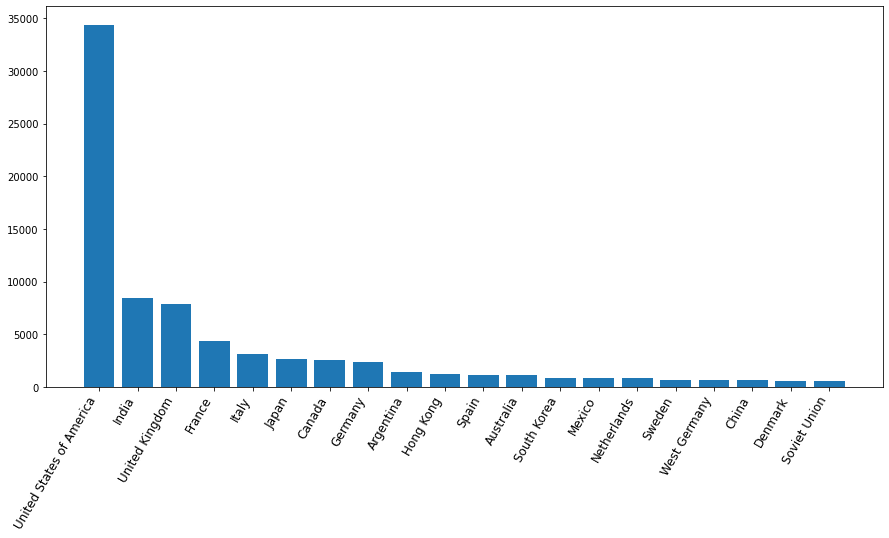

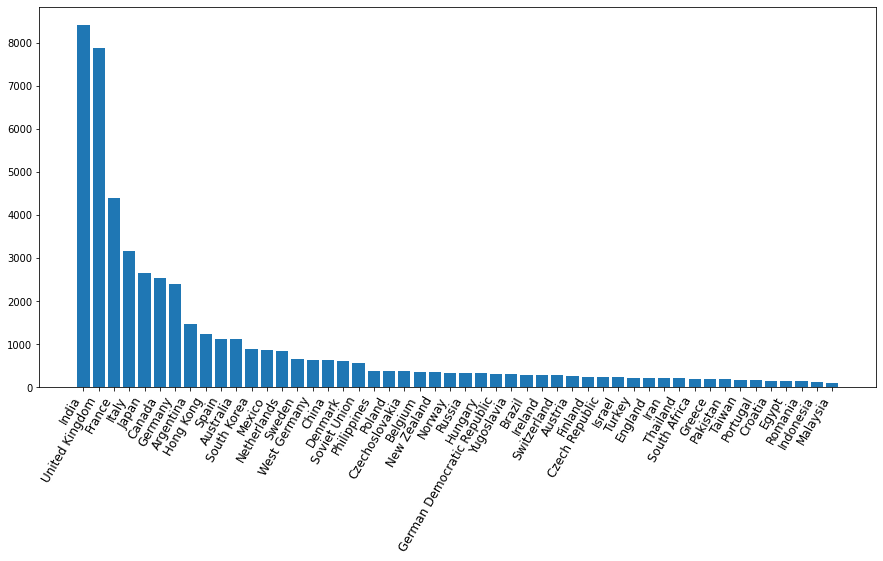

In [218]:



from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count.head(20).index.to_series(),count.head(20))
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count[1:51].index.to_series(),count[1:51])
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);


In [219]:


# sort movies by date 
data[(data['release_date']<'2000') & (data['release_date']>='1995')]
set1=data[data['release_date']<'1985']
set2=data[data['release_date']>'1985']
set1=set1['countries']
set2=set2['countries']
def analysis(set) :
    set=set.apply(lambda row: (eval(row).values()))
    set= pd.DataFrame(set,columns=['countries'])
    exploded=pd.DataFrame([[c] for C in set['countries'] for c in C],columns=['countries'])
    # len(exploded['countries'].unique())
    count=exploded['countries'].value_counts()
    count.to_csv('test.csv')
    return count

c1=analysis(set1)
c2=analysis(set2)


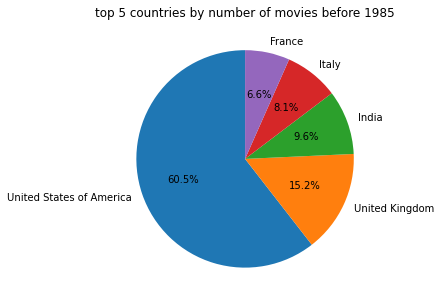

In [220]:
fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c1.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies before 1985')
plt.show()
# plot_countries


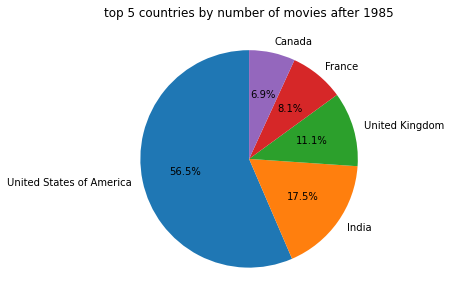

In [221]:

fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c2.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies after 1985')
plt.show()

# Train NN for predicting revenue

In [222]:
df_all_ohe.columns

Index(['freebase_id', 'name', 'runtime', 'release_year', 'isAdult', 'WR',
       'release_day', 'release_month', 'profit_modified',
       'total_gross_modified',
       ...
       'writers_Paruchuri Venkateswara Rao', 'writers_Rahi Masoom Reza',
       'writers_Robert A. McGowan', 'writers_Sachin Bhowmick',
       'writers_Satyanand', 'writers_Stephen King', 'writers_Tedd Pierce',
       'writers_Val Guest', 'writers_Warren Foster',
       'writers_William Shakespeare'],
      dtype='object', length=132)

In [223]:
movies

,countries
0,(United States of America)
1,(United States of America)
2,(Norway)
3,(United Kingdom)
4,(Germany)
...,...
81736,(United States of America)
81737,"(Ireland, United Kingdom)"
81738,(United States of America)
81739,(Japan)


In [224]:
df_all.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,ethnicity_score
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,8.392000e+03,8.392000e+03,82605.00000,82605.00000,82605.00000,82605.00000,82605.000000,33531.000000
mean,93.965487,1977.970463,0.002566,6.224498,15.658129,6.707718,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,-4.064115e-17,4.363016e-03,41303.00000,41303.00000,41303.00000,41303.00000,28494.129459,1.230145
std,59.949382,29.227202,0.050595,1.102334,8.708535,3.483166,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,1.000000e+00,1.000685e-02,23846.15383,23846.15383,23846.15383,23846.15383,22434.175447,0.505826
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,-4.359263e-01,7.660325e-07,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,-4.171539e-01,1.886180e-04,20652.00000,20652.00000,20652.00000,20652.00000,8758.000000,1.000000
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,-3.380567e-01,9.801326e-04,41303.00000,41303.00000,41303.00000,41303.00000,23903.000000,1.000000
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,-4.740050e-02,3.888687e-03,61954.00000,61954.00000,61954.00000,61954.00000,42900.000000,1.000000
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,2.356975e+01,2.402221e-01,82605.00000,82605.00000,82605.00000,82605.00000,82604.000000,5.000000


In [225]:
df_all_ohe.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Val Guest,writers_Warren Foster,writers_William Shakespeare
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,...,82605.000000,82605.000000,82605.000000,82605.000000,82605.000000,82605.00000,82605.000000,82605.000000,82605.000000,82605.000000
mean,93.965487,1977.970463,0.002566,6.224498,15.658129,6.707718,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,...,0.000811,0.000678,0.000799,0.000884,0.000605,0.00069,0.001259,0.000593,0.001259,0.001198
std,59.949382,29.227202,0.050595,1.102334,8.708535,3.483166,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,...,0.028468,0.026028,0.028255,0.029715,0.024595,0.02626,0.035460,0.024348,0.035460,0.034598
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [226]:
movies_with_gross = df_all_ohe[df_all_ohe['pageviews'].notna()]

In [227]:
movies_with_gross.drop(['freebase_id', 'name', 'release_day', 'profit_modified'], axis=1, inplace=True)

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/2019227165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_gross.drop(['freebase_id', 'name', 'release_day', 'profit_modified'], axis=1, inplace=True)


In [228]:
movies_with_gross.head()

,runtime,release_year,isAdult,WR,release_month,total_gross_modified,budget_modified,pageviews,genre_Action,genre_Action/Adventure,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Val Guest,writers_Warren Foster,writers_William Shakespeare
0,98.0,2001.0,0.0,4.900185,8.0,1.870026e+07,NaN,16013.456439,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83.0,1988.0,0.0,5.839121,NaN,NaN,NaN,19.982872,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,106.0,1983.0,NaN,NaN,NaN,NaN,NaN,249.941370,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,35.0,1913.0,0.0,6.836211,5.0,NaN,NaN,46.708333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,NaN,1974.0,NaN,NaN,NaN,NaN,NaN,27.495059,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
movies_with_gross.describe()

,runtime,release_year,isAdult,WR,release_month,total_gross_modified,budget_modified,pageviews,genre_Action,genre_Action/Adventure,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Val Guest,writers_Warren Foster,writers_William Shakespeare
count,40004.000000,46775.000000,26232.000000,26232.000000,26926.000000,4.587000e+03,1.941000e+03,46823.000000,46823.000000,46823.000000,...,46823.000000,46823.00000,46823.000000,46823.000000,46823.000000,46823.000000,46823.000000,46823.000000,46823.000000,46823.000000
mean,93.046070,1976.218087,0.001982,6.217998,6.740065,6.483686e+07,5.140769e+07,2734.818491,0.110693,0.055592,...,0.000982,0.00079,0.001004,0.000940,0.000747,0.000662,0.001922,0.000705,0.001965,0.001068
std,62.820609,28.956367,0.044480,1.103847,3.490875,1.494537e+08,5.774172e+07,11517.211493,0.313756,0.229135,...,0.031329,0.02810,0.031667,0.030641,0.027330,0.025722,0.043800,0.026539,0.044283,0.032661
min,0.000000,1888.000000,0.000000,1.131770,1.000000,1.308762e+04,3.336750e+04,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,1954.000000,0.000000,5.614188,4.000000,2.772009e+06,1.379332e+07,47.083004,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,93.000000,1982.000000,0.000000,6.315095,7.000000,1.426108e+07,3.207750e+07,238.284585,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,107.000000,2003.000000,0.000000,6.998032,10.000000,5.694203e+07,6.576400e+07,1094.704134,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5700.000000,2020.000000,1.000000,9.414500,12.000000,1.939737e+09,4.862949e+08,410868.409091,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [230]:
movies_with_gross.shape

(46823, 128)

In [231]:
list(movies_with_gross.columns)

['runtime',
 'release_year',
 'isAdult',
 'WR',
 'release_month',
 'total_gross_modified',
 'budget_modified',
 'pageviews',
 'genre_Action',
 'genre_Action/Adventure',
 'genre_Adventure',
 'genre_Animation',
 'genre_Black-and-white',
 'genre_Comedy',
 'genre_Comedy film',
 'genre_Crime Fiction',
 'genre_Documentary',
 'genre_Drama',
 'genre_Family Film',
 'genre_Fantasy',
 'genre_Horror',
 'genre_Indie',
 'genre_Musical',
 'genre_Mystery',
 'genre_Other',
 'genre_Romance Film',
 'genre_Romantic comedy',
 'genre_Romantic drama',
 'genre_Science Fiction',
 'genre_Short Film',
 'genre_Silent film',
 'genre_Thriller',
 'genre_War film',
 'genre_World cinema',
 'languages_Cantonese',
 'languages_English',
 'languages_French',
 'languages_German',
 'languages_Hindi',
 'languages_Italian',
 'languages_Japanese',
 'languages_Korean',
 'languages_Malayalam',
 'languages_Other',
 'languages_Russian',
 'languages_Silent film',
 'languages_Spanish',
 'languages_Standard Mandarin',
 'languages_Tam

In [232]:
movies_with_gross = movies_with_gross.astype('float32')

In [233]:
dataset = movies_with_gross.copy()

In [234]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [235]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
runtime,32032.0,93.067307,59.926502,0.00000,80.000000,93.000000,108.000000,5700.000000
release_year,37420.0,1976.162964,28.916868,1888.00000,1954.000000,1982.000000,2003.000000,2020.000000
isAdult,21048.0,0.001853,0.043010,0.00000,0.000000,0.000000,0.000000,1.000000
WR,21048.0,6.216456,1.102380,1.13177,5.609008,6.312913,6.998276,9.414499
release_month,21496.0,6.732834,3.488681,1.00000,4.000000,7.000000,10.000000,12.000000
...,...,...,...,...,...,...,...,...
writers_Stephen King,37458.0,0.000587,0.024223,0.00000,0.000000,0.000000,0.000000,1.000000
writers_Tedd Pierce,37458.0,0.002029,0.045004,0.00000,0.000000,0.000000,0.000000,1.000000
writers_Val Guest,37458.0,0.000774,0.027810,0.00000,0.000000,0.000000,0.000000,1.000000
writers_Warren Foster,37458.0,0.001789,0.042260,0.00000,0.000000,0.000000,0.000000,1.000000


In [236]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pageviews')
test_labels = test_features.pop('pageviews')

In [237]:
train_features.shape

(37458, 127)

In [238]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Normalization
from tensorflow.python.keras.models import Sequential

# from tensorflow.keras.metrics import Recall, Precision
# from tensorflow_addons.metrics import F1Score

ModuleNotFoundError: No module named 'tensorflow'

total_gross_modified ~ runtime + release_year + isAdult + WR + release_month + budget_modified + pageviews + genre + languages + countries + directors + writers

In [ ]:
model = Sequential()
model.add(Normalization(axis=-1))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [ ]:
model.build((0, 127))
model.summary()

In [239]:
history = model.fit(train_features, train_labels, batch_size=32, epochs=10, validation_split=0.2)

NameError: name 'model' is not defined

# Project Milestone 3: data story

## Study data for separate genre

In [ ]:
# Create list of top 15 genre: 
print(genres[genres>1000][0:15])
top_genre = genres[genres>1000][0:15].index.tolist()

## Top movies for three success features

We sort df_all by most successful movies according to our three success features. Note that we keep here duplicates for future use.

In [ ]:
# Success in terms of profit: 
df_all_top_profit = df_all_expanded.sort_values('profit_modified', ascending=False)
df_all_top_profit.head(3)

In [ ]:
# Success in terms of weighted IMDB rating: 
df_all_top_WR = df_all_expanded.sort_values('WR', ascending=False)
df_all_top_WR.head(3)

## Impact of director

In [ ]:
# Most succesful directors in terms of profit
top_20_directors = df_all_top_profit[df_all_top_profit['genre']=='Drama'].dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors'])[0:20] # Remove NaN directors

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies for drama genre", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
print('pandas',pd.__version__,'networkX', nx.__version__,'pyvis', pyvis.__version__)

Network graph:
Node size: feature score
Edge width: collaboration score

In [ ]:
N = 15 # number of nodes 
top_N_directors = directors_score.sort_values(by='Score')[0:N]

In [ ]:
ls_top_directors = top_N_directors['directors'].tolist()
director_pairs_score = director_pairs_score.rename({'directors': 'director_pair', 'Score':'Score_pair'}, axis = 1)

# Create a merged dataframe where we have only collaborations which include top directors
df = top_N_directors.merge(director_pairs_score.rename({'directors': 'director_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on='directors',right_on='directors0')
top_N_directors_graph = df[df['directors1'].isin(df['directors'])]
#del df

# Contains only top directors collaboration
print('Length of dataframe is: ',len(top_N_directors_graph))
top_N_directors_graph.head()


In [ ]:
# Complete with top directors without collaboration
top_N_directors_graph = top_N_directors.merge(top_N_directors_graph,how='left',on=['directors','Score'])
top_N_directors_graph.sample(5)

## Static Version

In [ ]:
#graph esthetic parameters
max_node_size = 1000
max_edge_width = 100

# normalize scores and define their width in the graph
nodes_scores = top_N_directors_graph.drop_duplicates(subset='directors')['Score']
nodes_size = np.array(nodes_scores)
nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
nodes_size *= max_node_size

#Rescale edge weights: 
weights = top_N_directors_graph['Score_pair'].dropna()
weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
#weights *= max_edge_width
top_N_directors_graph['weight_edge'] = weights

# Create edge data:
edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                      'target' : top_N_directors_graph['directors1'].tolist(),
                      'weight' : top_N_directors_graph['weight_edge'].tolist()})

# Create node data:
node_data = pd.DataFrame({'name' : top_N_directors_graph['directors'].tolist(),
                      'score': top_N_directors_graph['Score'].tolist()}).drop_duplicates(subset='name')


G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
# Remove edges to NaN
G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
# Remove node NaN
G.remove_node(np.nan)

#nx.set_node_attributes(G, pd.Series(nodes.gender, index=nodes.node).to_dict(), 'gender')

In [ ]:
# Generate layout for visualization
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))


# Visualize graph components
nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.title("Impactful directors")

#plt.savefig('../output/network_sparse.png', dpi = 500)
plt.show()


## Animated version

In [ ]:

# Create vis network
net = Network(notebook=True)
# Load the networkx graph
net.from_nx(G)
# Show
net.show("example.html")

## Create function to generalise to all cases:

In [ ]:
import networkx as nx

In [ ]:
def draw_bubble_graph(df_score, df_pair_score, feature, genre, N):
    # df_score: dataframe with score of independent features
    # df_pair_score: dataframe with score of paired features
    # feature: string name of column in dataframe to process 'directors', 'actor_name', 'genre'
    # genre: movie genre subset to plot
    # N: number of feature points to include
    
    # Remove empty entries:
    df_score = df_score.drop(index=df_score[df_score[feature] == ''].index,axis=0)
    
    top_N = df_score.sort_values(by='Score')[0:N]
    ls_top = top_N[feature].tolist()
    df_pair_score = df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1)

    # Create a merged dataframe where we have only collaborations which include top features
    df = top_N.merge(df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on=feature, right_on= feature +'0')
    top_N_graph = df[df[feature +'1'].isin(df[feature])]
    #del df

    # Contains only top collaboration
    top_N_graph.head()
    
    # Complete with top individuals without collaboration
    top_N_graph = top_N.merge(top_N_graph,how='left',on=[feature,'Score'])
    top_N_graph.sample(5)
    
    # Create network graph: 
    
    #graph esthetic parameters
    max_node_size = 1000
    max_edge_width = 100

    # normalize scores and define their width in the graph
    nodes_scores = top_N_graph.drop_duplicates(subset=feature)['Score']
    nodes_size = np.array(nodes_scores)
    nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
    nodes_size *= max_node_size

    #Rescale edge weights: 
    weights = top_N_graph['Score_pair'].dropna()
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                          'target' : top_N_graph[feature +'1'].tolist(),
                          'weight' : top_N_graph['weight_edge'].tolist()})

    # Create node data:
    node_data = pd.DataFrame({'name' : top_N_graph[feature].tolist(),
                          'score': top_N_graph['Score'].tolist()}).drop_duplicates(subset='name')


    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
    # Remove node NaN
    if np.nan in G:
        G.remove_node(np.nan)
            

    # Generate layout for visualization
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(10, 10))


    # Visualize graph components
    nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.title("Impactful " + feature)

    #plt.savefig('../output/network_sparse.png', dpi = 500)
    plt.show()



In [ ]:
draw_bubble_graph(directors_score ,director_pairs_score, 'directors', 'a', 15)

In [ ]:
draw_bubble_graph(actors_score ,actor_pairs_score, 'actor_name', 'a', 15)

In [ ]:
draw_bubble_graph(genre_score ,genre_pairs_score, 'genre', 'insertgenre', 15)

In [ ]:
df_score=genre_score 
df_pair_score = genre_pairs_score
feature = 'genre'
N=15

In [ ]:
    # Remove empty entries:
    df_score = df_score.drop(index=df_score[df_score[feature] == ''].index,axis=0)
    
    top_N = df_score.sort_values(by='Score')[0:N]
    ls_top = top_N[feature].tolist()
    df_pair_score = df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1)

    # Create a merged dataframe where we have only collaborations which include top features
    df = top_N.merge(df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on=feature, right_on= feature +'0')
    top_N_graph = df[df[feature +'1'].isin(df[feature])]
    #del df

    # Contains only top collaboration
    top_N_graph.head()
    
    # Complete with top individuals without collaboration
    top_N_graph = top_N.merge(top_N_graph,how='left',on=[feature,'Score'])
    top_N_graph.sample(5)
    
    # Create network graph: 
    
    #graph esthetic parameters
    max_node_size = 1000
    max_edge_width = 100

    # normalize scores and define their width in the graph
    nodes_scores = top_N_graph.drop_duplicates(subset=feature)['Score']
    nodes_size = np.array(nodes_scores)
    nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
    nodes_size *= max_node_size

    #Rescale edge weights: 
    weights = top_N_graph['Score_pair'].dropna()
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                          'target' : top_N_graph[feature +'1'].tolist(),
                          'weight' : top_N_graph['weight_edge'].tolist()})

    # Create node data:
    node_data = pd.DataFrame({'name' : top_N_graph[feature].tolist(),
                          'score': top_N_graph['Score'].tolist()}).drop_duplicates(subset='name')


    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
    # Remove node NaN
    if np.nan in G:
        G.remove_node(np.nan)
            


In [ ]:
node_data

In [ ]:
edge_data

In [ ]:
top_N_graph

In [ ]:

    # Generate layout for visualization
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(10, 10))


    # Visualize graph components
    nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.title("Impactful " + feature)

    #plt.savefig('../output/network_sparse.png', dpi = 500)
    plt.show()


